# Project 1: Classifying Names with a Character-Level RNN

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

## pytorch 深度学习框架

打算手撕这个框架，进而加深对于深度学习的实现的理解

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preparing Torch

use GPU acceleration

In [2]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(torch.get_default_device())
device

cpu


device(type='cuda')

## Preparing the Data

从官网上下载了数据
- 1. 定义和清理我们的数据。
    - 最初，我们需要将 Unicode 转换为普通的 ASCII，以限制 RNN 输入层的复杂性。
    - 这是通过将 Unicode 字符串转换为 ASCII，并仅允许一小部分指定的字符来实现的。

- 2. 将unicode字符转换为ascii字符的方式
    - 归一化处理：使用unicodedata.normalize('NFD', s)将输入字符串s转换为其分解形式
    - 过滤掉组合符号：通过列表推导式遍历归一化后的每个字符c，并检查其类别是否不是'Mn'（Mark, Nonspacing），即非间距标记
    - 字符集限制：进一步筛选出那些存在于预定义集合allowed_characters中的字符
    - 拼接结果：最后，使用''.join(...)将所有符合条件的字符连接起来形成一个新的字符串，并返回这个字符串。
    - 貌似中文不行，但是其他字符可以

In [3]:
import string
import unicodedata

# 生成ascii字符：'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'
allowed_characters = string.ascii_letters + ".,;"
n_letters = len(allowed_characters)

# 将unicode字符转换为ascii字符，详情见于“https://stackoverflow.com/a/518232/2809427”

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in allowed_characters)

# Example usage
original_string = "你好Ślusàrski"
ascii_string = unicodeToAscii(original_string)
print(f"Original: {original_string}")
print(f"Converted to ASCII: {ascii_string}")

Original: 你好Ślusàrski
Converted to ASCII: Slusarski


## 将字符串变成tensor格式
采用 *one-hot* 编码

- lineToTensor(line) 解释：
    - 初始化张量：使用torch.zeros(len(line), 1, n_letters)创建一个全零的三维张量。张量的形状是(len(line), 1, n_letters)，其中：
        - len(line) 是字符串中字符的数量。
        - 1 表示批次大小（batch size），这里假设每次处理一个字符。
        - n_letters 是字母表中不同字符的数量。
    - 遍历字符串中的每个字符：使用enumerate(line)来获取字符串中每个字符及其对应的索引li和字符本身letter。
    - 设置独热向量：对于每个字符，找到其在字母表中的索引（通过letterToIndex(letter)函数），然后将对应位置的值设置为1。这样就形成了一个独热向量，表示该字符。
    - 返回张量：最终返回构造好的三维张量。

对于其他RNN任务，我也可以使用类似的方法。

In [4]:
def letterToIndex(letter):
    return allowed_characters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print (f"The letter 'a' becomes {lineToTensor('a')}")
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]])
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

## Dataset and DataLoader

制作自己的数据集：
- NameDataset(Dataset):
    - 定义了一个名为NamesDataset的类，并使其继承自torch.utils.data.Dataset

    - 设置属性：
        - self.data_dir: 存储数据目录路径
        - self.load_time: 记录数据加载的时间
        - labels_set: 用于存储唯一的标签集合

    - 初始化列表：
        - self.data:存储所有姓名
        - self.data_tensor:存储每个姓名对应的张量表示
        - self.labels:存储每个姓名对应的标签
        - self.labels_tensors:存储每个标签对应的张量表示

    - 查找文件内容：
        - 使用glob.glob查找指定目录下所有的.txt文件。
        - 对于每个文件名，提取其基础名称作为标签。
    
    - 读取文件内容：
        - 打开每个文件并读取内容，按行分割得到姓名列表。
        - 将每个姓名及其对应的标签添加到相应的列表中。
        - 同时，使用lineToTensor函数将每个姓名转换为张量，并添加到self.data_tensors中。
    
    - 唯一标签列表：
        - 将labels_set转换为列表self.labels_uniq，以便后续查找索引。
    
    - 标签tensor：
        - 遍历所有标签，将其转换为对应的整数索引，并创建一个长整型张量。
        - 将这些张量添加到self.labels_tensors中。

    


In [5]:
from io import open
import glob
import os
import time
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.load_time = time.localtime()
        labels_set = set()

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        text_files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

                
# Example usage
if __name__ == "__main__":
    # Assuming there are files like 'English.txt', 'Spanish.txt' in the directory './data/names'
    dataset = NamesDataset('/harddisk1/SZC-Project/NLP-learning/RNNs/data/names')
    print(f"Number of samples: {len(dataset)}")
    label_tensor, data_tensor, data_label, data_item = dataset[1]
    print(f"Label tensor: {label_tensor}")
    print(f"Data tensor: {data_tensor}")
    print(f"Data label: {data_label}")
    print(f"Data item: {data_item}")

Number of samples: 20074
Label tensor: tensor([4])
Data tensor: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [6]:
data_dir = '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names'
text_files = glob.glob(os.path.join(data_dir, "*.txt"))
text_files

['/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Russian.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Arabic.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/German.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Portuguese.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Scottish.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Spanish.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Korean.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Italian.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Greek.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Czech.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Vietnamese.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Japanese.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/French.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/Chinese.txt',
 '/harddisk1/SZC-Project/NLP-learning/RNNs/data/

使用torch.utils.data.random_split对于创建的NameDataset实例进行数据集划分，划分比例：80/20（train/test）


In [14]:
data_dir = '/harddisk1/SZC-Project/NLP-learning/RNNs/data/names'
alldata = NamesDataset(data_dir)

train_set, test_set = torch.utils.data.random_split(alldata, [0.85, 0.15])
generator = torch.Generator(device=device).manual_seed(2025)

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## Create RNN model

使用 `nn.RNN` 作为模型，它支持cuDNN-accelerated kernels

### 模型结构

- nn.RNN 层
- nn.Linear 层
- nn.LogSoftmax 层

### 参数
模型参数如下：
- input_size: 57
- hidden_size: 128
- output_size: 18

### 数学公式证明

### 图片



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output

def label_from_output(output, output_labels):
    # top_n: 包含最大值（即模型预测的最高置信度得分）
    # top_i: 包含最大值对应的索引
    top_n, top_i = output.topk(1) # 从张量中找到前 k 个最大值及其对应的索引
    label_i = top_i[0].item() 
    return output_labels[label_i],label_i

n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))

input = lineToTensor("Albert")
output = rnn(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))


tensor([[-2.9069, -2.9546, -3.0173, -2.8129, -2.7744, -2.9757, -2.9209, -2.9025,
         -2.6886, -2.8856, -2.9635, -2.9499, -2.8964, -2.9560, -2.8887, -2.7683,
         -2.8363, -2.9950]], grad_fn=<LogSoftmaxBackward0>)
('Korean', 8)


In [44]:
top_n, top_i = output.topk(1)
top_n, top_i

(tensor([[-2.7271]], grad_fn=<TopkBackward0>), tensor([[1]]))

In [45]:
alldata.labels_uniq

['English',
 'Greek',
 'Russian',
 'Italian',
 'Scottish',
 'German',
 'Japanese',
 'Irish',
 'Portuguese',
 'Polish',
 'Korean',
 'Dutch',
 'Arabic',
 'French',
 'Chinese',
 'Vietnamese',
 'Spanish',
 'Czech']

## 训练模型
### 步骤


In [16]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size=64, report_every=50, learning_rate=0.1, criterion=nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # keep tracking the loss
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        # clear the gradients
        rnn.zero_grad() 

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches)//n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss
            
            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)
        
        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
start = time.time()
all_losses = train(rnn, train_set, n_epoch=45, learning_rate=0.1, report_every=5)
end = time.time()
print(f"training took {end-start}s")   

training on data set with n = 17063
5 (11%): 	 average batch loss = 0.8946103854321412
10 (22%): 	 average batch loss = 0.7150233981373546
15 (33%): 	 average batch loss = 0.6010326792647067
20 (44%): 	 average batch loss = 0.5057877667355979
25 (56%): 	 average batch loss = 0.4274837839941264
30 (67%): 	 average batch loss = 0.36536827977076647
35 (78%): 	 average batch loss = 0.3220969772880962
40 (89%): 	 average batch loss = 0.29020784559701135
45 (100%): 	 average batch loss = 0.25936425680573655
training took 228.501314163208s


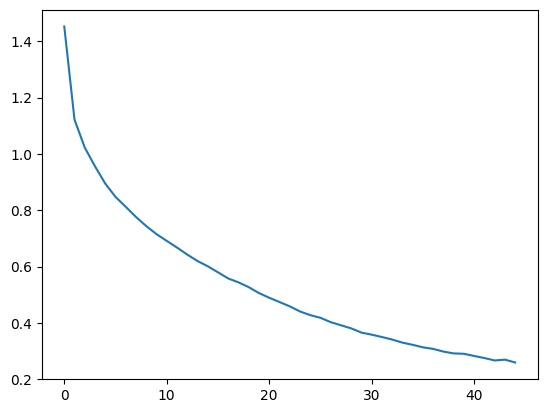

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## Evaluating the RNN model

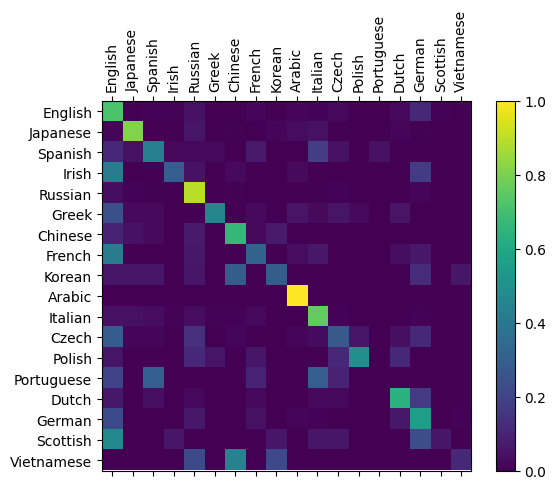

In [18]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes),len(classes))

    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i,guess_i] += 1

    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i]/denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    

evaluate(rnn, test_set, classes=alldata.labels_uniq)